Attempt to import and simple analysis over the files

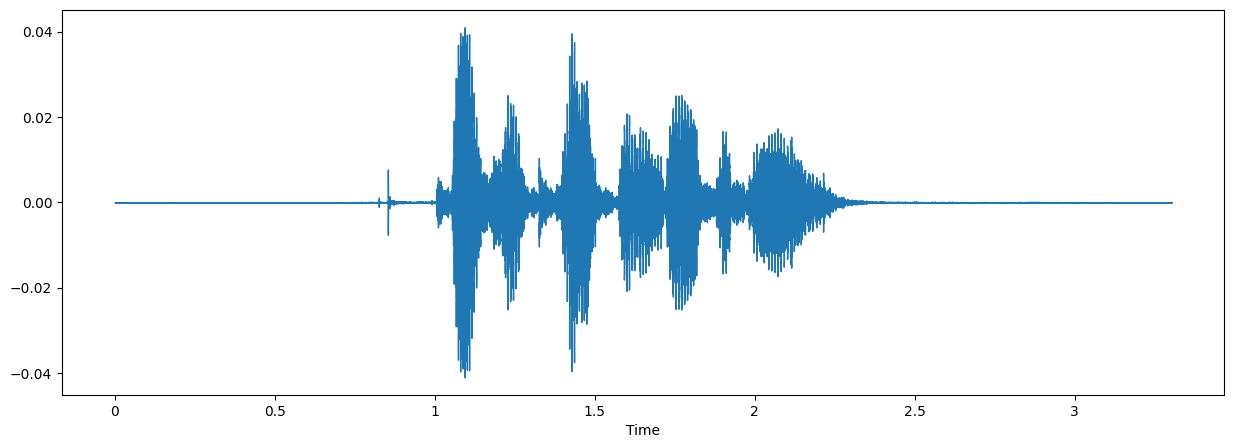

In [1]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import glob
import os, sys
import matplotlib.pyplot as plt

data, sampling_rate = librosa.load('/Users/chunyiyang/Desktop/emotion-audio-classification/data/archive/Actor_01/03-01-01-01-01-01-01.wav')

%matplotlib inline
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

Processes the audio

/var/folders/lj/20qxvm111sg60tvdf5yxflpr0000gn/T/ipykernel_97637/2821282304.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('/Users/chunyiyang/Desktop/emotion-audio-classification/data/archive/Actor_01/03-01-01-01-01-01-01.wav')
/var/folders/lj/20qxvm111sg60tvdf5yxflpr0000gn/T/ipykernel_97637/2821282304.py:12: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


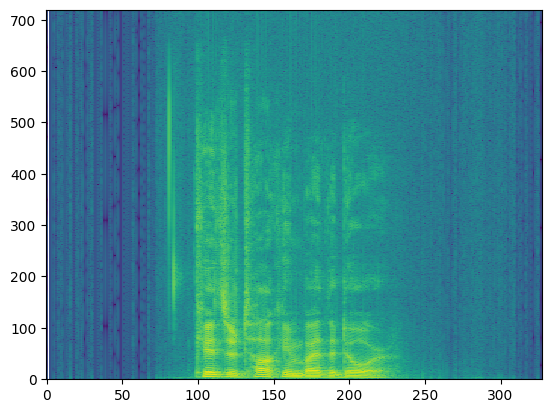

In [2]:
import scipy.io.wavfile
sr,x = scipy.io.wavfile.read('/Users/chunyiyang/Desktop/emotion-audio-classification/data/archive/Actor_01/03-01-01-01-01-01-01.wav')
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin
window = np.hamming(nwin)
nn = range(nwin, len(x), nstep)
X = np.zeros( (len(nn), nfft//2) )
for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))
plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')
plt.show()


This script processes wav audio files from a specified directory, extracts emotion labels, intensity, gender, and other metadata from filenames, and constructs a pandas DataFrame.

In [180]:
import os
import pandas as pd

DATA_PATH = '/Users/chunyiyang/Desktop/emotion-audio-classification/data/archive'

rows = []
skipped = []

for dirpath, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        if not filename.lower().endswith('.wav'):
            continue

        base = filename.rsplit('.', 1)[0]     
        identifiers = base.split('-')        
        if len(identifiers) != 7:
            skipped.append(filename)           
            continue

        try:
            M, V, E, I, S, R, A = identifiers
            emotion = int(E)
            if emotion == 8:                   
                emotion = 0

            emotion_intensity = 'normal' if int(I) == 1 else 'strong'
            gender = 'female' if int(A) % 2 == 0 else 'male'

            rows.append({
                "Emotion": emotion,
                "Emotion intensity": emotion_intensity,
                "Gender": gender,
                "Path": os.path.join(dirpath, filename)
            })
        except Exception as e:
            skipped.append(f"{filename} -> {repr(e)}")
            continue

data = pd.DataFrame(rows)
print("Total Samples:", len(data), " | Skipped:", len(skipped))
print("example：")
display(data.head())



Total Samples: 2880  | Skipped: 0
example：


,Emotion,Emotion intensity,Gender,Path
0,5,normal,female,/Users/chunyiyang/Desktop/emotion-audio-classi...
1,6,normal,female,/Users/chunyiyang/Desktop/emotion-audio-classi...
2,6,strong,female,/Users/chunyiyang/Desktop/emotion-audio-classi...
3,5,strong,female,/Users/chunyiyang/Desktop/emotion-audio-classi...
4,7,normal,female,/Users/chunyiyang/Desktop/emotion-audio-classi...


Only Keep Speech

In [123]:

def is_speech(path):
    name = os.path.basename(path).split('.')[0]
    parts = name.split('-')
    return len(parts) == 7 and parts[1] == '01'

data = data[data['Path'].apply(is_speech)].reset_index(drop=True)
print("After speech-only filter:", len(data))


After speech-only filter: 2880


This code loads and standardizes audio clips to 3-second segments at 48kHz, padding shorter files with zeros to ensure uniform length for processing.

In [39]:
mel_spectrograms = []
signals = []
SAMPLE_RATE = 48000
for i, file_path in enumerate(data.Path):
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3,)))
#     print("len_signal",len(signal))
    signal[:len(audio)] = audio
    signals.append(signal)
    print("\r Processed {}/{} files".format(i,len(data)),end='')
# print("signals_before_stack:",signals)
signals = np.stack(signals,axis=0)
# print("signals_after_stack:",signals)

 Processed 2879/2880 files

In [ ]:
This code splits the audio dataset into train/val/test sets (80%/10%/10%) by speaker ID (actor) to avoid data leakage, where:

actor_from_path() extracts speaker IDs from filenames (e.g., "03.wav" → 3)

Splitting ensures each speaker’s clips stay in one set (no overlap)

Inputs (X) are the audio signals, labels (Y) are emotion classes (converted to int32)

In [ ]:

import re, numpy as np

def actor_from_path(p):
    m = re.search(r'(\d{2})\.wav$', p)
    return int(m.group(1)) if m else None

actors = np.array(sorted({actor_from_path(p) for p in data['Path']}))
rng = np.random.RandomState(42); rng.shuffle(actors)

n = len(actors)
train_act = set(actors[:int(0.8*n)])
val_act   = set(actors[int(0.8*n):int(0.9*n)])
test_act  = set(actors[int(0.9*n):])

train_idx = data['Path'].apply(lambda p: actor_from_path(p) in train_act).values
val_idx   = data['Path'].apply(lambda p: actor_from_path(p) in val_act).values
test_idx  = data['Path'].apply(lambda p: actor_from_path(p) in test_act).values

X = signals
Y = data['Emotion'].values.astype(np.int32) 

X_train, Y_train = X[train_idx], Y[train_idx]
X_val,   Y_val   = X[val_idx],   Y[val_idx]
X_test,  Y_test  = X[test_idx],  Y[test_idx]

print(X_train.shape, X_val.shape, X_test.shape)


(2280, 144000) (240, 144000) (360, 144000)


Adding AWGN for enhancement

In [42]:
import numpy as np

def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30):
    signal = signal.astype(np.float32)
    T = signal.shape[0]

    noise = np.random.normal(size=(augmented_num, T)).astype(np.float32)

    norm_constant = 2.0**(num_bits - 1)
    s_norm = signal / norm_constant
    n_norm = noise / norm_constant

    Ps = np.sum(s_norm ** 2) / T                           # signal power
    Pn = np.sum(n_norm ** 2, axis=1) / T                   # each noise power
    snr_db = np.random.uniform(snr_low, snr_high, size=augmented_num)
    snr_lin = 10.0 ** (snr_db / 10.0)
    K = np.sqrt(Ps / (Pn * snr_lin)).astype(np.float32)    # (augmented_num,)
    K = K[:, None]                                          # (augmented_num, 1)

    return signal[None, :] + K * noise                      # (augmented_num, T)

aug_signals = []
aug_labels  = []

for i in range(X_train.shape[0]):
    sig = X_train[i, :]
    noisy_batch = addAWGN(sig, augmented_num=2, snr_low=15, snr_high=30)  # (2, T)
    aug_signals.append(noisy_batch)
    aug_labels.append(np.full(noisy_batch.shape[0], Y_train[i], dtype=Y_train.dtype))
    if i % 100 == 0:
        print(f"\rProcessed {i}/{X_train.shape[0]}", end="")

aug_signals = np.vstack(aug_signals)                # (N_aug, T)
aug_labels  = np.concatenate(aug_labels, axis=0)    # (N_aug,)

X_train = np.concatenate([X_train, aug_signals], axis=0)
Y_train = np.concatenate([Y_train, aug_labels], axis=0)

print("\nDone.")
print(f"X_train:{X_train.shape}, Y_train:{Y_train.shape}")


Processed 2300/2302
Done.
X_train:(6906, 144000), Y_train:(6906,)


Obtaining MEL Spectrogram

MEL spectrogram shape:  (128, 563)


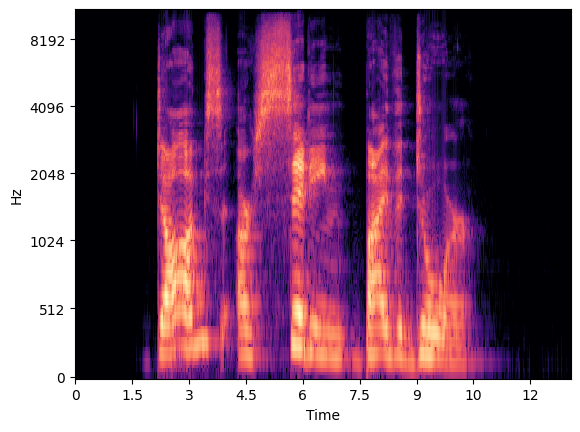

In [43]:
def getMELspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,    #hop_length两个window之间的跳跃间隔
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db
 
# test function
audio, sample_rate = librosa.load(data.loc[0,'Path'], duration=3, offset=0.5,sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3,)))
signal[:len(audio)] = audio
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
print('MEL spectrogram shape: ',mel_spectrogram.shape)

CNN Branch: 4 conv blocks (with BN/ReLU/MaxPool/Dropout) extract local spectrogram features

Transformer Branch: Processes time-frequency patterns via 4 encoder layers (d_model=64, 4 heads)

Fusion: Concatenates flattened CNN features with Transformer embeddings for classification

Output: Produces both logits and softmax probabilities for num_emotions classes

In [44]:
import torch
import torch.nn as nn
 
class ParallelModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        # conv block
        self.conv2Dblock = nn.Sequential(
            # 1. conv block
            nn.Conv2d(in_channels=1,
                       out_channels=16,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
            # 2. conv block
            nn.Conv2d(in_channels=16,
                       out_channels=32,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 3. conv block
            nn.Conv2d(in_channels=32,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 4. conv block
            nn.Conv2d(in_channels=64,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3)
        )
        # Transformer block
        self.transf_maxpool = nn.MaxPool2d(kernel_size=[2,4], stride=[2,4])
        transf_layer = nn.TransformerEncoderLayer(d_model=64, nhead=4, dim_feedforward=512, dropout=0.4, activation='relu')
        self.transf_encoder = nn.TransformerEncoder(transf_layer, num_layers=4)
        # Linear softmax layer
        self.out_linear = nn.LazyLinear(num_emotions)
        self.dropout_linear = nn.Dropout(p=0)
        self.out_softmax = nn.Softmax(dim=1)
    def forward(self,x):
        # conv embedding
        conv_embedding = self.conv2Dblock(x) #(b,channel,freq,time)
        conv_embedding = torch.flatten(conv_embedding, start_dim=1) # do not flatten batch dimension
        # transformer embedding
        x_reduced = self.transf_maxpool(x)
        x_reduced = torch.squeeze(x_reduced,1)
        x_reduced = x_reduced.permute(2,0,1) # requires shape = (time,batch,embedding)
        transf_out = self.transf_encoder(x_reduced)
        transf_embedding = torch.mean(transf_out, dim=0)
        # concatenate
        complete_embedding = torch.cat([conv_embedding, transf_embedding], dim=1) 
        # final Linear
        output_logits = self.out_linear(complete_embedding)
        output_logits = self.dropout_linear(output_logits)
        output_softmax = self.out_softmax(output_logits)
        return output_logits, output_softmax

Preprocess audio before feeding to models

In [45]:
import numpy as np, torch
from torch.utils.data import Dataset, DataLoader
import librosa

SR = 48000
N_MELS = 128
N_FFT = 1024
HOP = 256  

def wav_to_logmel(y, sr=SR):
    if y.dtype != np.float32:
        y = y.astype(np.float32)
    if np.max(np.abs(y)) > 1.0:
        y = y / 32768.0 
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP,
                                       n_mels=N_MELS, power=2.0)
    S = librosa.power_to_db(S, ref=np.max)
    return S.astype(np.float32)  # (n_mels, T)


This code converts raw audio clips into fixed-length log-Mel spectrogram batches for neural network input. It ensures uniform 3-second clips (144k samples at 48kHz) and pads/trims audio, then extracts 128-band Mel spectrograms with consistent time dimensions across batches.

Key outputs are 4D arrays shaped (batch_size, 1 channel, 128 mel bins, time steps) - ready for CNN/Transformer models like your ParallelModel. The print shows final dataset shapes (e.g., (N,1,128,T) for train/val/test splits).

In [109]:
import numpy as np, librosa

SR = 48000
CLIP_SECONDS = 3.0
TARGET_SAMPLES = int(SR * CLIP_SECONDS)
N_MELS, N_FFT, HOP = 128, 1024, 256

def fix_len(y, target=TARGET_SAMPLES):
    y = y.astype(np.float32)
    if y.ndim == 2: y = y.mean(axis=1)  
    if len(y) < target: return np.pad(y, (0, target - len(y)))
    return y[:target]

def wav_to_logmel(y, sr=SR):
    y = y.astype(np.float32)
    if np.max(np.abs(y)) > 1.0: y = y / 32768.0
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP,
                                       n_mels=N_MELS, power=2.0)
    S = librosa.power_to_db(S, ref=np.max).astype(np.float32) 
    return S

def to_batch_logmel(X):
    ms = []
    for y in X:
        m = wav_to_logmel(fix_len(y))
        ms.append(m)
    T = max(m.shape[1] for m in ms)
    out = np.zeros((len(ms), 1, N_MELS, T), dtype=np.float32)
    for i, m in enumerate(ms):
        out[i, 0, :, :m.shape[1]] = m
    return out

Xtr_mel = to_batch_logmel(X_train)
Xva_mel = to_batch_logmel(X_val)
Xte_mel = to_batch_logmel(X_test)
print(Xtr_mel.shape, Xva_mel.shape, Xte_mel.shape)  

(6906, 1, 128, 563) (285, 1, 128, 563) (293, 1, 128, 563)


Flattens each spectrogram into 1D vectors (reshape(B, -1)) to compute mean/std across all frequency-time bins

Fits the scaler on training data (fit_transform) and applies it to validation/test sets (transform)

Reshapes back to original 4D format (batch, channel, mel_bins, time_steps) for PyTorch compatibility

In [110]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

B, C, H, W = Xtr_mel.shape
Xtr_f = Xtr_mel.reshape(B, -1)
Xva_f = Xva_mel.reshape(Xva_mel.shape[0], -1)
Xte_f = Xte_mel.reshape(Xte_mel.shape[0], -1)

Xtr_f = scaler.fit_transform(Xtr_f)
Xva_f = scaler.transform(Xva_f)
Xte_f = scaler.transform(Xte_f)

Xtr_mel = Xtr_f.reshape(B, C, H, W).astype(np.float32)
Xva_mel = Xva_f.reshape(Xva_mel.shape[0], C, H, W).astype(np.float32)
Xte_mel = Xte_f.reshape(Xte_mel.shape[0], C, H, W).astype(np.float32)

Creates PyTorch data loaders for training/validation/testing

In [112]:


import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

BATCH_SIZE = 32

train_loader = DataLoader(
    TensorDataset(torch.from_numpy(Xtr_mel), torch.from_numpy(Y_train.astype(np.int64))),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=0
)
val_loader = DataLoader(
    TensorDataset(torch.from_numpy(Xva_mel), torch.from_numpy(Y_val.astype(np.int64))),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(Xte_mel), torch.from_numpy(Y_test.astype(np.int64))),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)
num_classes = int(len(np.unique(Y_train)))

print("classes:", num_classes)


classes: 8


configures class-weighted loss (for imbalanced data) and optimization setup with AdamW (3e-4 LR), weight decay (1e-4), and learning rate reduction on plateaus (0.5x every 5 stagnant epochs).

In [126]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(Y_train)
class_w = compute_class_weight('balanced', classes=classes, y=Y_train)
class_w = torch.tensor(class_w, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_w, label_smoothing=0.05)

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=5)


preprocesses audio data into Mel spectrograms and creates PyTorch dataloaders for training

In [53]:
SR, N_MELS, N_FFT, HOP = 48000, 128, 1024, 256

def wav_to_logmel(y, sr=SR):
    import librosa, numpy as np
    y = y.astype(np.float32)
    if np.max(np.abs(y)) > 1.0: y = y / 32768.0
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP,
                                       n_mels=N_MELS, power=2.0)
    S = librosa.power_to_db(S, ref=np.max).astype(np.float32)  
    return S

def to_batch_logmel(X):
    ms = [wav_to_logmel(w) for w in X]        
    T = max(m.shape[1] for m in ms)
    X4 = np.zeros((len(ms), 1, N_MELS, T), dtype=np.float32)
    for i, m in enumerate(ms):
        t = m.shape[1]
        X4[i, 0, :, :t] = m
    return X4

Xtr_mel = to_batch_logmel(X_train)
Xva_mel = to_batch_logmel(X_val)
Xte_mel = to_batch_logmel(X_test)

import torch
from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(TensorDataset(torch.from_numpy(Xtr_mel), torch.from_numpy(Y_train.astype(np.int64))),
                          batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(TensorDataset(torch.from_numpy(Xva_mel), torch.from_numpy(Y_val.astype(np.int64))),
                          batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(TensorDataset(torch.from_numpy(Xte_mel), torch.from_numpy(Y_test.astype(np.int64))),
                          batch_size=32, shuffle=False, num_workers=0)


In [108]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()

def scale_mel(X, fit=False):
    B, C, H, W = X.shape
    Xf = X.reshape(B, -1)
    Xf = scaler.fit_transform(Xf) if fit else scaler.transform(Xf)
    return Xf.reshape(B, C, H, W)

X_train_mel = scale_mel(Xtr_mel, fit=True)
X_val_mel   = scale_mel(Xva_mel,   fit=False)
X_test_mel  = scale_mel(Xte_mel,  fit=False)


Implements SpecAugment

In [127]:
import torch.nn as nn, torch

class SpecAugment(nn.Module):
    def __init__(self, freq_mask=24, time_mask=48, num_masks=2):
        super().__init__()
        self.freq_mask = freq_mask; self.time_mask = time_mask; self.num_masks = num_masks
    def forward(self, x):  # x: (B,1,128,T)
        if not self.training: return x
        B, C, F, T = x.size(); x = x.clone()
        for b in range(B):
            for _ in range(self.num_masks):
                f = torch.randint(0, self.freq_mask+1, (1,)).item()
                if f>0:
                    f0 = torch.randint(0, max(1, F-f), (1,)).item()
                    x[b,:,f0:f0+f,:] = 0
                t = torch.randint(0, self.time_mask+1, (1,)).item()
                if t>0:
                    t0 = torch.randint(0, max(1, T-t), (1,)).item()
                    x[b,:,:,t0:t0+t] = 0
        return x

augment = SpecAugment().to(device)


Implements a complete training loop with:

Training Phase

    Applies SpecAugment to spectrograms

    Tracks loss/accuracy with progress bars

    Updates model via backpropagation

Validation Phase

    Evaluates model without augmentation

    Adjusts learning rate via scheduler

Early Stopping

    Saves best model when validation loss improves

    Stops after 12 epochs without improvement

In [128]:
import math
from tqdm.auto import tqdm

best_val = math.inf
epochs = 180
no_improve = 0
patience = 12

for ep in range(1, epochs+1):
    # ---- train ----
    model.train(); augment.train()
    tot, correct, n = 0.0, 0, 0
    for xb, yb in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {ep} train", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        xb = augment(xb)

        logits, _ = model(xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad(); loss.backward()
        optimizer.step()

        tot += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        n += xb.size(0)
    tr_loss, tr_acc = tot/n, correct/n

    # ---- val ----
    model.eval(); augment.eval()
    vtot, vcorrect, vn = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in tqdm(val_loader, total=len(val_loader), desc=f"Epoch {ep} val", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            logits, _ = model(xb)
            loss = criterion(logits, yb)
            vtot += loss.item() * xb.size(0)
            vcorrect += (logits.argmax(1) == yb).sum().item()
            vn += xb.size(0)
    val_loss, val_acc = vtot/vn, vcorrect/vn

    scheduler.step(val_loss)

    print(f"Epoch {ep:03d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {val_loss:.4f}/{val_acc:.3f} | lr {optimizer.param_groups[0]['lr']:.2e}")
    if val_loss < best_val - 1e-5:
        best_val = val_loss; no_improve = 0
        torch.save(model.state_dict(), "best_parallel_ser.pt"); print("  ✓ saved best")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {ep}")
            break


Epoch 001 | train 1.7543/0.350 | val 1.6071/0.463 | lr 3.00e-04
  ✓ saved best


Epoch 002 | train 1.6724/0.390 | val 1.5290/0.449 | lr 3.00e-04
  ✓ saved best


Epoch 003 | train 1.6021/0.420 | val 1.5130/0.474 | lr 3.00e-04
  ✓ saved best


Epoch 004 | train 1.5549/0.451 | val 1.7866/0.382 | lr 3.00e-04


Epoch 005 | train 1.5073/0.469 | val 1.3167/0.544 | lr 3.00e-04
  ✓ saved best


Epoch 006 | train 1.4515/0.497 | val 1.3200/0.547 | lr 3.00e-04


Epoch 007 | train 1.4142/0.515 | val 1.2759/0.561 | lr 3.00e-04
  ✓ saved best


Epoch 008 | train 1.3617/0.539 | val 1.1610/0.632 | lr 3.00e-04
  ✓ saved best


Epoch 009 | train 1.3233/0.553 | val 1.1435/0.642 | lr 3.00e-04
  ✓ saved best


Epoch 010 | train 1.2746/0.571 | val 1.1690/0.600 | lr 3.00e-04


Epoch 011 | train 1.2361/0.592 | val 1.2473/0.600 | lr 3.00e-04


Epoch 012 | train 1.2093/0.603 | val 1.3194/0.568 | lr 3.00e-04


Epoch 013 | train 1.1872/0.618 | val 1.0219/0.670 | lr 3.00e-04
  ✓ saved best


Epoch 014 | train 1.1487/0.634 | val 1.1314/0.656 | lr 3.00e-04


Epoch 015 | train 1.1197/0.647 | val 0.9880/0.695 | lr 3.00e-04
  ✓ saved best


Epoch 016 | train 1.1004/0.656 | val 0.9535/0.730 | lr 3.00e-04
  ✓ saved best


Epoch 017 | train 1.0667/0.666 | val 0.8773/0.737 | lr 3.00e-04
  ✓ saved best


Epoch 018 | train 1.0522/0.681 | val 0.8421/0.786 | lr 3.00e-04
  ✓ saved best


Epoch 019 | train 1.0289/0.683 | val 0.9204/0.733 | lr 3.00e-04


Epoch 020 | train 1.0149/0.703 | val 0.7806/0.807 | lr 3.00e-04
  ✓ saved best


Epoch 021 | train 0.9812/0.709 | val 0.9747/0.716 | lr 3.00e-04


Epoch 022 | train 0.9719/0.715 | val 0.9137/0.754 | lr 3.00e-04


Epoch 023 | train 0.9593/0.723 | val 0.8392/0.779 | lr 3.00e-04


Epoch 024 | train 0.9295/0.733 | val 0.8317/0.804 | lr 3.00e-04


Epoch 025 | train 0.9103/0.742 | val 0.7599/0.796 | lr 3.00e-04
  ✓ saved best


Epoch 026 | train 0.9151/0.734 | val 0.8223/0.814 | lr 3.00e-04


Epoch 027 | train 0.8927/0.748 | val 0.8048/0.800 | lr 3.00e-04


Epoch 028 | train 0.8649/0.764 | val 0.7880/0.814 | lr 3.00e-04


Epoch 029 | train 0.8557/0.760 | val 0.7980/0.789 | lr 3.00e-04


Epoch 030 | train 0.8421/0.775 | val 0.7822/0.825 | lr 3.00e-04


Epoch 031 | train 0.8437/0.776 | val 0.6469/0.870 | lr 3.00e-04
  ✓ saved best


Epoch 032 | train 0.8217/0.786 | val 0.7029/0.853 | lr 3.00e-04


Epoch 033 | train 0.8112/0.782 | val 0.6417/0.898 | lr 3.00e-04
  ✓ saved best


Epoch 034 | train 0.8001/0.791 | val 0.6036/0.895 | lr 3.00e-04
  ✓ saved best


Epoch 035 | train 0.7821/0.794 | val 0.5832/0.895 | lr 3.00e-04
  ✓ saved best


Epoch 036 | train 0.7816/0.794 | val 0.6491/0.881 | lr 3.00e-04


Epoch 037 | train 0.7593/0.810 | val 0.6829/0.884 | lr 3.00e-04


Epoch 038 | train 0.7527/0.813 | val 0.6739/0.870 | lr 3.00e-04


Epoch 039 | train 0.7332/0.821 | val 0.6679/0.860 | lr 3.00e-04


Epoch 040 | train 0.7374/0.818 | val 0.6595/0.856 | lr 3.00e-04


Epoch 041 | train 0.7250/0.826 | val 0.6314/0.895 | lr 1.50e-04


Epoch 042 | train 0.6849/0.843 | val 0.6213/0.923 | lr 1.50e-04


Epoch 043 | train 0.6700/0.855 | val 0.6148/0.912 | lr 1.50e-04


Epoch 044 | train 0.6637/0.852 | val 0.6086/0.891 | lr 1.50e-04


Epoch 045 | train 0.6761/0.849 | val 0.6133/0.923 | lr 1.50e-04


Epoch 046 | train 0.6563/0.855 | val 0.6107/0.912 | lr 1.50e-04


Epoch 047 | train 0.6503/0.857 | val 0.6521/0.877 | lr 7.50e-05
Early stopping at epoch 47


Evaluating the model

In [149]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.load_state_dict(torch.load("/Users/chunyiyang/Desktop/emotion-audio-classification/notebooks/best_parallel_ser.pt", map_location=device))
model.eval()
preds, gts = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits, _ = model(xb)
        preds.append(logits.argmax(1).cpu().numpy())
        gts.append(yb.numpy())

preds = np.concatenate(preds)
gts   = np.concatenate(gts)
print(classification_report(gts, preds, digits=3))
print(confusion_matrix(gts, preds))


              precision    recall  f1-score   support

           0      0.833     0.897     0.864        39
           1      0.615     0.800     0.696        20
           2      0.905     0.974     0.938        39
           3      0.969     0.795     0.873        39
           4      0.968     0.769     0.857        39
           5      0.949     0.949     0.949        39
           6      0.897     0.897     0.897        39
           7      0.833     0.897     0.864        39

    accuracy                          0.877       293
   macro avg      0.871     0.872     0.867       293
weighted avg      0.888     0.877     0.878       293

[[35  2  0  0  0  0  0  2]
 [ 0 16  1  1  0  0  2  0]
 [ 0  1 38  0  0  0  0  0]
 [ 3  3  0 31  0  1  1  0]
 [ 0  4  1  0 30  0  1  3]
 [ 0  0  0  0  0 37  0  2]
 [ 2  0  0  0  1  1 35  0]
 [ 2  0  2  0  0  0  0 35]]
